# DS1003 Homework 2

## Data Set and Programming Overview

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import setup_problem as sp
import ridge_regression as rr
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

# setup_problem.py

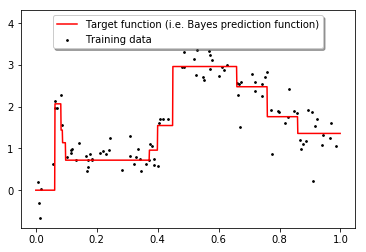

In [12]:
"""
Generating target function, featurizer, and train/validation/test splits for the Lasso homework.

Author: David S. Rosenberg <david.davidr@gmail.com>
License: Creative Commons Attribution 4.0 International License
"""

from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle


def step_fn_generator(stepLoc=0):
    def f(x):
        ret = np.zeros(len(x))
        ret[x >= stepLoc] = 1
        return ret
    return f

def linear_comb_generator(fns, coefs):
    def f(x):
        return sum(fns[i](x) * coefs[i] for i in range(len(fns)))
    return f

def get_target_and_featurizer(num_basis_fns = 100, num_nonzero = 10, coefs_true=None):
    # We'll create a basis of step functions on the interval [0,1]. We'll then
    # construct a linear combination of these step functions to be our target
    # function. We'll construct a function to "featurize" an input in [0,1]
    # into the evaluations of all functions in the basis on the input.
    # Optionally: If coefs_true is provided, they will be used to generate
    # target_fn and featurize.
    # Construct basis, to be used for generating target function

    if coefs_true is not None:
        num_basis_fns = len(coefs_true)
    else:
        nonzero_indices = np.random.choice(num_basis_fns, num_nonzero)
        coefs_true = np.zeros(num_basis_fns)
        coefs_true[nonzero_indices] = np.random.randn(num_nonzero)

    all_basis_fns = [step_fn_generator(stepLoc=s)
                     for s in np.linspace(0, 1, num_basis_fns, endpoint=False)]

    # Construct target function (the Bayes prediction function)
    target_fn = linear_comb_generator(all_basis_fns, coefs_true)

    def featurize(x):
        n = len(x)
        # Featurize input values in [0,1]
        X_ftrs = np.empty((n, num_basis_fns))
        for ftr_num in range(num_basis_fns):
            X_ftrs[:, ftr_num] = all_basis_fns[ftr_num](x)
        return X_ftrs

    return target_fn, coefs_true, featurize

def generate_data(target_fn, n=1000, noise_scale=.25, tdof=6):
    # Construct dataset
    x = np.sort(np.random.rand(n)) #chooses uniformly from [0,1)
    y_target = target_fn(x)
    y = y_target + noise_scale * np.random.standard_t(tdof,n)
    return x, y

def get_data_splits(x, y, test_frac=.2):
    ## Based on https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb
    n = len(y)
    shuffled_indices = np.random.permutation(n)
    n_test = int(n * test_frac)
    n_train = n - n_test
    indices_test = shuffled_indices[:n_test]
    indices_train = shuffled_indices[n_test:]
    y_train = y[indices_train]
    x_train = x[indices_train]
    y_test = y[indices_test]
    x_test = x[indices_test]
    return x_train, y_train, x_test, y_test

def generate_problem(n=200, num_basis_fns=400, num_nonzero=10, noise_scale=.25, tdof=6, test_frac=.2, write_problem=False, file_name="lasso_data.pickle"):
    target_fn, coefs_true, featurize = get_target_and_featurizer(num_basis_fns, num_nonzero)
    x, y = generate_data(target_fn, n, noise_scale, tdof)
    x_train, y_train, x_test, y_test = get_data_splits(x, y, test_frac)

    if write_problem:
        print ("Saving problem to disk.")
        data = {"coefs_true":coefs_true, "x_train":x_train,
                "y_train":np.copy(y_train), "x_test":x_test, "y_test":y_test}
        with open(file_name, 'wb') as outfile:
            pickle.dump(data, outfile, protocol=2)

    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def reconstitute_problem(coefs_true, x_train, y_train, x_test, y_test):
    target_fn, coefs_true, featurize = get_target_and_featurizer(coefs_true=coefs_true)
    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def load_problem(file_name):
    f_myfile = open(file_name, 'rb')
    data = pickle.load(f_myfile)
    f_myfile.close()
    return reconstitute_problem(data["coefs_true"], data["x_train"], data["y_train"],
                                data["x_test"], data["y_test"])

def main():
    lasso_data_fname = "lasso_data.pickle"
    LOAD_PROBLEM=True
    GENERATE_PROBLEM=False
    WRITE_PROBLEM=False
    if GENERATE_PROBLEM:
        n=1000
        test_frac=.9
        num_basis_fns=400
        num_nonzero=10
        noise_scale=.25 # scale factor on noise
        tdof = 6 # degrees of freedom of t-distribution generating noise
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = generate_problem(n=n, num_basis_fns=num_basis_fns, num_nonzero=num_nonzero, noise_scale=noise_scale, test_frac=test_frac, write_problem=WRITE_PROBLEM, file_name=lasso_data_fname)

    if LOAD_PROBLEM:
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Let's plot the target function (i.e. the Bayes prediction function) as
    # well as the noisy observations from the training data, as a function of
    # the original input space, which is the interval [0,1).
    fig, ax = plt.subplots()
    plt.scatter(x_train, y_train, s=3, color='k', label='Training data')
    x = np.arange(0,1,.001)
    ax.plot(x, target_fn(x), 'r', label='Target function (i.e. Bayes prediction function)')
    legend = ax.legend(loc='upper center', shadow=True)
    plt.show(block=False)

if __name__ == '__main__':
    main()


### ridge_regression.py

In [ ]:
# %load ridge_regression.py
"""
Ridge regression using scipy's minimize function and demonstrating the use of
sklearn's framework.

Author: David S. Rosenberg <david.davidr@gmail.com>
License: Creative Commons Attribution 4.0 International License
"""
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

from setup_problem import load_problem

class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)



def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):
    # First run sklearn ridge regression and extract the coefficients
    from sklearn.linear_model import Ridge
    # Fit with sklearn -- need to multiply l2_reg by sample size, since their
    # objective function has the total square loss, rather than average square
    # loss.
    n = X_train.shape[0]
    sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
    sklearn_ridge.fit(X_train, y_train)
    sklearn_ridge_coefs = sklearn_ridge.coef_

    # Now run our ridge regression and compare the coefficients to sklearn's
    ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
    ridge_regression_estimator.fit(X_train, y_train)
    our_coefs = ridge_regression_estimator.w_

    print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                           np.arange(1,3,.3)
                                             ))) }]

    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize,
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True)
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots()
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

def main():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    #Visualize training data
    fig, ax = plt.subplots()
    ax.imshow(X_train)
    ax.set_title("Design Matrix: Color is Feature Value")
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Example Number")
    plt.show(block=False)

    # Compare our RidgeRegression to sklearn's.
    compare_our_ridge_with_sklearn(X_train, y_train, l2_reg = 1.5)

    # Do hyperparameter tuning with our ridge regression
    grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
    print(results)

    # Plot validation performance vs regularization parameter
    fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
    ax.semilogx(results["param_l2reg"], results["mean_test_score"])
    ax.grid()
    ax.set_title("Validation Performance vs L2 Regularization")
    ax.set_xlabel("L2-Penalty Regularization Parameter")
    ax.set_ylabel("Mean Squared Error")
    fig.show()

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    name = "Target Parameter Values (i.e. Bayes Optimal)"
    pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

    l2regs = [0, grid.best_params_['l2reg'], 1]
    X = featurize(x)
    for l2reg in l2regs:
        ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
        ridge_regression_estimator.fit(X_train, y_train)
        name = "Ridge with L2Reg="+str(l2reg)
        pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X) })

    f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
    f.show()

    f = compare_parameter_vectors(pred_fns)
    f.show()

if __name__ == '__main__':
  main()


### 1.1 Load the problem from disk into memory with load_problem.

In [18]:
x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize = sp.load_problem('lasso_data.pickle')

### 1.2 Use the featurize function to map from a one-dimensional input space to a d-dimensional feature space.

In [19]:
X_train = featurize(x_train)
X_test = featurize(x_test)

### 1.3 Visualize the design matrix of the featurized data. 

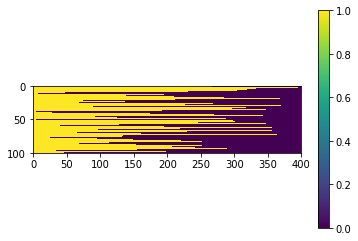

In [20]:
plt.imshow(X_train)
plt.colorbar()
plt.show()

array([1, 1, 0])

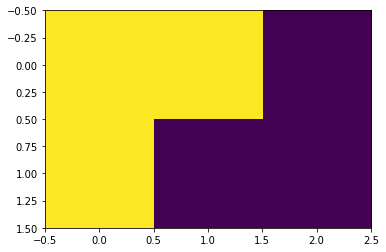

In [47]:
# a = np.array([[1,1,0],[1,0,0]])
# plt.imshow(a)
# a[0]

### other parts try

In [80]:
[{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                           np.arange(1,3,.3)
                                             ))) }]

[{'l2reg': array([1.0e-06, 1.0e-05, 1.0e-04, 1.0e-03, 1.0e-02, 1.0e-01, 1.0e+00,
         1.3e+00, 1.6e+00, 1.9e+00, 2.2e+00, 2.5e+00, 2.8e+00])}]

In [88]:
from sklearn.model_selection import PredefinedSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 1, 1])
test_fold = [-1, -1, 0, 0]
ps = PredefinedSplit(test_fold)
ps.get_n_splits()
print(ps)       
for train_index, test_index in ps.split():
    print("TRAIN:", train_index, "TEST:", test_index)

PredefinedSplit(test_fold=array([-1, -1,  0,  0]))
TRAIN: [0 1] TEST: [2 3]


## Ridge Regression

### 2.1 Find $\lambda$ that minimizes the empirical risk

In [21]:
# param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
#                                            np.arange(1,3,.3)
#                                              ))) }]
grid, result = rr.do_grid_search_ridge(X_train, y_train, X_test, y_test)

In [22]:
result

,param_l2reg,mean_test_score,mean_train_score
0,0.000001,0.172579,0.006752
1,0.000010,0.172464,0.006752
2,0.000100,0.171345,0.006774
3,0.001000,0.162705,0.008285
4,0.010000,0.141887,0.032767
5,0.100000,0.144566,0.094953
6,1.000000,0.171068,0.197694
7,1.300000,0.179521,0.216591
8,1.600000,0.187993,0.233450
9,1.900000,0.196361,0.248803


/Users/zihaoguo/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


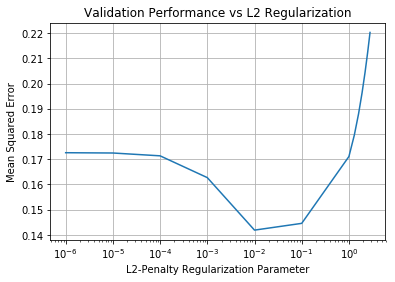

In [23]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
#ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(result["param_l2reg"], result["mean_test_score"])
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
fig.show()

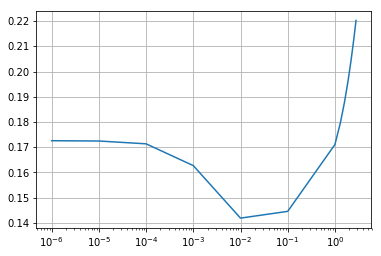

In [8]:
plt.semilogx(result.iloc[:,0],result.iloc[:,1])
plt.grid()

### 2.2 Visualize prediction function

In [9]:
coefs_true.shape

(400,)

In [24]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

l2regs = [0, grid.best_params_['l2reg']]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = rr.RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

In [25]:
np.argmax(pred_fns[1]['coefs'])

269

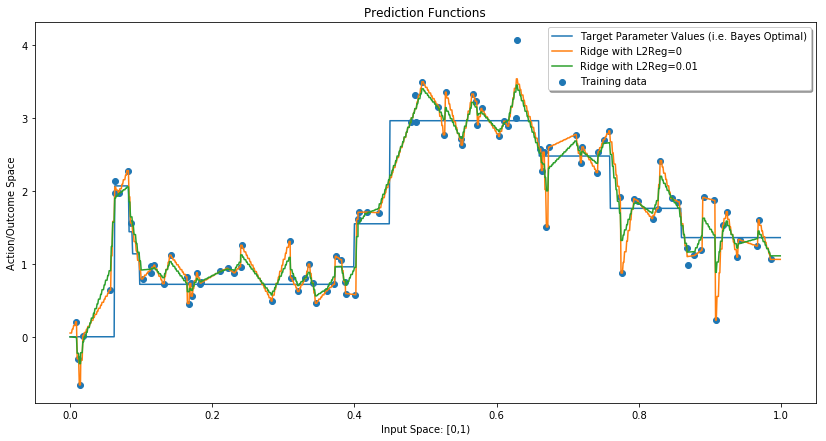

In [11]:
fig1=rr.plot_prediction_functions(x, pred_fns, x_train, y_train)

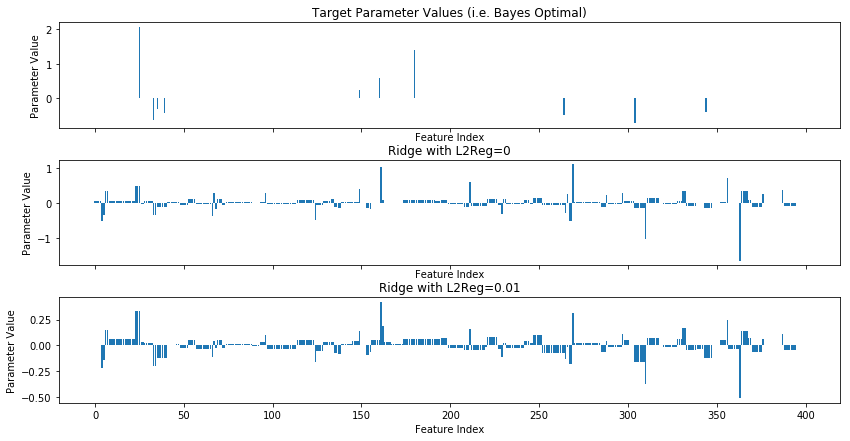

In [12]:
fig2 = rr.compare_parameter_vectors(pred_fns)

### 2.3 Examine the model coefficients

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    

In [26]:
def bigger_than_threshold(x, threshold):
    if abs(x) > threshold:
        return 1
    else:
        return 0

In [29]:
pred_fns[2]['coefs']

array([-2.27660355e-03, -2.27660517e-03, -2.27660355e-03, -2.27660355e-03,
       -2.17478592e-01, -1.42072839e-01,  1.50262978e-01,  1.50262978e-01,
        6.49156146e-02,  6.49156160e-02,  6.49156162e-02,  6.49156162e-02,
        6.49156154e-02,  6.49156154e-02,  6.49156154e-02,  6.49156143e-02,
        6.49156146e-02,  6.49156160e-02,  6.49156162e-02,  6.49156162e-02,
        6.49156154e-02,  6.49156154e-02,  6.49156154e-02,  3.32391847e-01,
        3.32391847e-01,  3.32391845e-01,  2.80685560e-02,  2.80685560e-02,
        1.92126045e-02,  1.92126045e-02,  1.92126045e-02,  1.92126029e-02,
        1.92126053e-02, -2.05160866e-01, -2.05160866e-01, -1.21308113e-01,
       -1.21308113e-01, -1.21308113e-01, -1.21308112e-01, -1.21308113e-01,
       -1.21308116e-01,  2.12440890e-03,  2.12440715e-03,  2.12440715e-03,
        2.12440663e-03,  2.12440663e-03,  9.47096910e-03,  9.47096948e-03,
       -2.70462565e-02, -2.70462565e-02, -2.70462588e-02, -2.70462588e-02,
       -2.70462587e-02,  

Confusion matrix, without normalization
[[  5 385]
 [  0  10]]


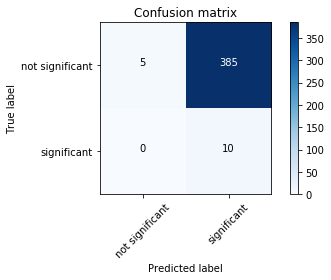

Confusion matrix, without normalization
[[  8 382]
 [  0  10]]


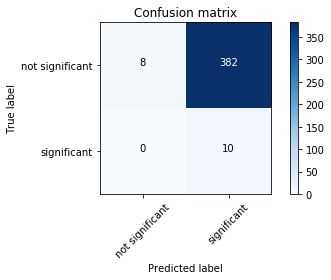

Confusion matrix, without normalization
[[349  41]
 [  3   7]]


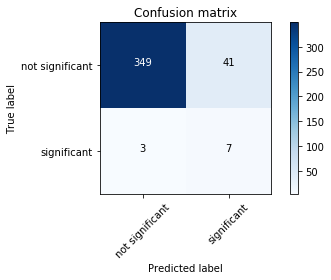

In [28]:
thresholds = 10.**np.array([-6,-3,-1])
for threshold in thresholds:
    coefs_true_binary = [bigger_than_threshold(x,0) for x in coefs_true]
    coefs_pred_binary = [bigger_than_threshold(x, threshold) for x in pred_fns[2]['coefs']]
    cf = confusion_matrix(coefs_true_binary, coefs_pred_binary)
    classes = ['not significant', 'significant']
    plot_confusion_matrix(cf,classes)

## 3.1 Experiments with the Shooting Algorithm (Lasso Regression)

### 3.1.2 Lasso Solution (For this question, we'll use $\lambda$ =1

In [354]:
class LassoRegression(BaseEstimator, RegressorMixin):
    def __init__(self, l1reg=1):
        if l1reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l1reg = l1reg
        self.obj_history = None
        self.val_history = None
        self.w = None
    def fit(self, X, y, optimize = "ccd", init_w = "zero", constant_w = None, scale = None, delta = 1e-8, 
            max_iterations = 400*1000, verbose = False, useValidate=False, X_val=None, y_val=None):
        """
        X: (n,d)
        y: (n,)
        optimize:
            - "ccd" : cyclic coordinate decent
            - "rcd" : randomized coordinate decent
        init_w:
            - "zero": initiate w with np.zeros(d)
            - "Murphy" : initiate w with ridge regession solution as Murphy suggested.
            - "random" : initiate w with random generated numbers. 
                         scale will be ignored if not using this option.
            - "constant": initiate w with constants. (Can be used for a warm start)
                        constant_w will be ignired if using this option 
                         
        useValidate:
            - When True, calculate the validation score using X_val, y_val
            - When False, ignore the X_val, y_val
        """        
        n, d = X.shape
        y = y.reshape(-1) # convert y to 1-dim array, in case we're given a row vector
        
        def lasso_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) 
            l1_norm = np.sum(np.abs(w))
            objective = empirical_risk + self.l1reg * l1_norm
            return objective
        self.lasso_obj_ = lasso_obj
        
        if init_w == "zero":
            w = np.zeros(d)
        elif init_w == "Murphy":
            w = self._Murphy_init(X,y)
        elif init_w == "random":
            w = np.random.rand(d)*scale
        elif init_w == "constant":
            w = constant_w
            
        obj_his = []
        val_his = []
        for iteration in range(max_iterations):
            if optimize == "ccd":
                j = iteration % d
            elif optimize == "rcd":
                j = np.random.randint(d)
            w = self._update_wj(X, y, w, j)
            obj = self.lasso_obj_(w)
            obj_his.append(obj)
#             print(obj)
#             print(obj_his)
            if verbose and iteration % 147 == 0:
                print("Iteration: %d, updating w[%d], loss = %f" % (iteration,j,obj))
            if useValidate and iteration%400==0 and iteration>399:
                val_risk = self.validate(X_val, y_val, w)
                val_his.append(val_risk)
            if iteration%400==0 and iteration>399 and abs(obj_his[iteration] - obj_his[iteration-400]) < delta: 
                #after some iterations, if it converges, we make it an early stop here
                print(iteration/400)
                break
        self.w = w
        self.obj_history = obj_his
        self.val_history = val_his
        return self
    
    def predict(self, X):
        """
        X: (n,d)
        """
        predictions = None
        if self.w is not None:
            predictions = np.dot(X,self.w)
        return predictions
    
    def validate(self, X_val, y_val, w):
        n,d = X_val.shape
        predictions = np.dot(X_val,w)
        residual = y_val - predictions
        empirical_risk = np.sum(residual**2)/n
        return empirical_risk  
                
           
    def _compute_aj(self, X, j):
        """
        X: (n,d)
        """
        aj = 2 * np.dot(X[:,j].T, X[:,j])
        return aj
    
    def _compute_cj(self, X, y, w, j):
        """
        X: (n,d)
        y: (n,)
        w: (d,)
        """
        cj = 2 * np.dot(X[:,j].T, y - np.dot(X, w) + w[j]*X[:,j].T)
        return cj
    
    def _update_wj(self, X, y, w, j):
        """
        using coordinate decent method to update the w[j]
        """
        aj = self._compute_aj(X, j)
        cj = self._compute_cj(X, y, w, j)
        if aj == 0:
            w[j] = 0
        elif cj>0: 
            w[j] = max(0, cj/aj- self.l1reg/aj)
        elif cj<0:
            w[j] = -max(0, -cj/aj- self.l1reg/aj)
        elif cj==0:
            w[j] = 0
                
        return w
    
    def _Murphy_init(self, X, y):
        """
        X:(n,d)
        y:(n,)
        w:(d,)
        """
        n,d = X.shape
        l1reg = self.l1reg
        return np.dot(np.linalg.inv(np.dot(X.T,X)+ l1reg*np.eye(d)), np.dot(X.T,y))

In [43]:
class LassoRegression(BaseEstimator, RegressorMixin):
    def __init__(self, l1reg=1):
        if l1reg <= 0:
            raise ValueError('Regularization penalty should be greater than 0.')
        self.l1reg = l1reg
        self.obj_history = None
        self.val_history = None
        self.w = None
    def fit(self, X, y, optimize = "ccd", init_w = "zero", constant_w = None, scale = None, delta = 1e-8, 
            max_iterations = 400*1000, verbose = False, useValidate=False, X_val=None, y_val=None):
        """
        X: (n,d)
        y: (n,)
        optimize:
            - "ccd" : cyclic coordinate decent
            - "rcd" : randomized coordinate decent
        init_w:
            - "zero": initiate w with np.zeros(d)
            - "Murphy" : initiate w with ridge regession solution as Murphy suggested.
            - "random" : initiate w with random generated numbers. 
                         scale will be ignored if not using this option.
            - "constant": initiate w with constants. (Can be used for a warm start)
                        constant_w will be ignired if using this option 
                         
        useValidate:
            - When True, calculate the validation score using X_val, y_val
            - When False, ignore the X_val, y_val
        """        
        n, d = X.shape
        y = y.reshape(-1) # convert y to 1-dim array, in case we're given a row vector
        
        def lasso_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) 
            l1_norm = np.sum(np.abs(w))
            objective = empirical_risk + self.l1reg * l1_norm
            return objective
        self.lasso_obj_ = lasso_obj
        
        if init_w == "zero":
            w = np.zeros(d)
        elif init_w == "Murphy":
            w = self._Murphy_init(X,y)
        elif init_w == "random":
            w = np.random.rand(d)*scale
        elif init_w == "constant":
            w = constant_w
            
        obj_his = []
        train_his = []
        val_his = []
        for iteration in range(max_iterations):
            if optimize == "ccd":
                j = iteration % d
            elif optimize == "rcd":
                j = np.random.randint(d)
            w = self._update_wj(X, y, w, j)
            obj = self.lasso_obj_(w)
            obj_his.append(obj)
#             print(obj)
#             print(obj_his)
            if iteration%400==0 and iteration>399:
                train_his.append(self.train_loss(X, y, w))
            if verbose and iteration % 147 == 0:
                print("Iteration: %d, updating w[%d], loss = %f" % (iteration,j,obj))
            if useValidate and iteration%400==0 and iteration>399:
                val_risk = self.validate(X_val, y_val, w)
                val_his.append(val_risk)
            if iteration%400==0 and iteration>399 and obj_his[iteration-400]-obj_his[iteration] < delta: 
                #after some iterations, if it converges, we make it an early stop here
                print(iteration/400)
                break
        self.w = w
        self.train_history = train_his
        self.obj_history = obj_his
        self.val_history = val_his
        return self
    
    def predict(self, X):
        """
        X: (n,d)
        """
        predictions = None
        if self.w is not None:
            predictions = np.dot(X,self.w)
        return predictions
    
    def train_loss(self, X, y, w):  # same as validate()
        n,d = X.shape
        predictions = np.dot(X, w)
        residual = y-predictions
        loss = np.sum(residual**2)/n
        return loss
    
    def validate(self, X_val, y_val, w):
        n,d = X_val.shape
        predictions = np.dot(X_val,w)
        residual = y_val - predictions
        empirical_risk = np.sum(residual**2)/n
        return empirical_risk  
                
           
    def _compute_aj(self, X, j):
        """
        X: (n,d)
        """
        aj = 2 * np.dot(X[:,j].T, X[:,j])
        return aj
    
    def _compute_cj(self, X, y, w, j):
        """
        X: (n,d)
        y: (n,)
        w: (d,)
        """
        cj = 2 * np.dot(X[:,j].T, y - np.dot(X, w) + w[j]*X[:,j].T)
        return cj
    
    def _update_wj(self, X, y, w, j):
        """
        using coordinate decent method to update the w[j]
        """
        aj = self._compute_aj(X, j)
        cj = self._compute_cj(X, y, w, j)
        if aj == 0:
            w[j] = 0
        elif cj>0: 
            w[j] = max(0, cj/aj- self.l1reg/aj)
        elif cj<0:
            w[j] = -max(0, -cj/aj- self.l1reg/aj)
        elif cj==0:
            w[j] = 0
                
        return w
    
    def _Murphy_init(self, X, y):
        """
        X:(n,d)
        y:(n,)
        w:(d,)
        """
        n,d = X.shape
        l1reg = self.l1reg
        return np.dot(np.linalg.inv(np.dot(X.T,X)+ l1reg*np.eye(d)), np.dot(X.T,y))

#### cyclic coordinate descent

In [44]:
la= LassoRegression(1)
la.fit(X_train, y_train, useValidate=True, X_val=X_test, y_val=y_test)

824.0


LassoRegression(l1reg=1)

In [436]:
la.val_history[-1]

0.16781937496866456

In [441]:
la.val_history[-1]

0.18373351596364473

In [45]:
lasso_ccd = LassoRegression(1)
lasso_ccd.fit(X_train, y_train)

824.0


LassoRegression(l1reg=1)

Text(0.5,1,'cyclic coordinate decent')

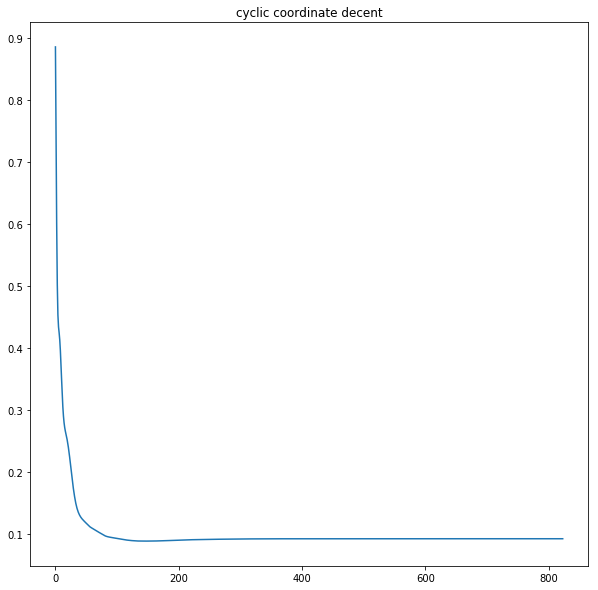

In [29]:
plt.subplots(figsize=(10,10))
plt.plot(lasso_ccd.train_history)
plt.title("cyclic coordinate decent")

#### randomized coordinate descent

In [46]:
lasso_rcd = LassoRegression(1)
lasso_rcd.fit(X_train,y_train, optimize = "rcd")

480.0


LassoRegression(l1reg=1)

(0.05, 0.05)

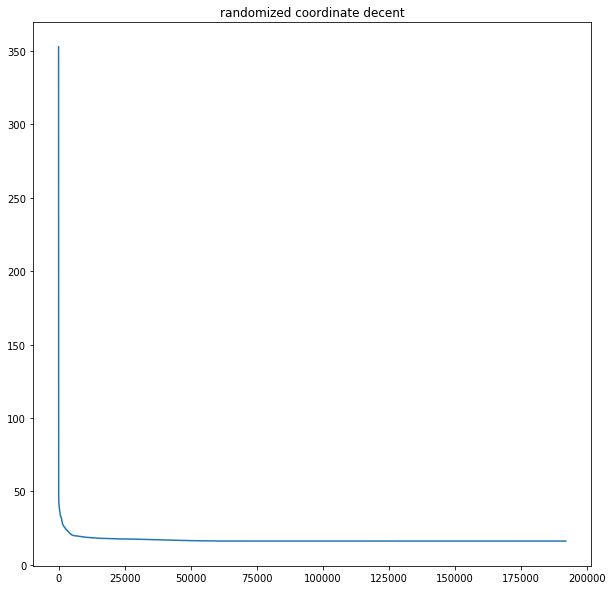

In [61]:
plt.subplots(figsize=(10,10))
plt.plot(lasso_rcd.obj_history)
plt.title("randomized coordinate decent")
plt.margins()

#### rcd vs ccd

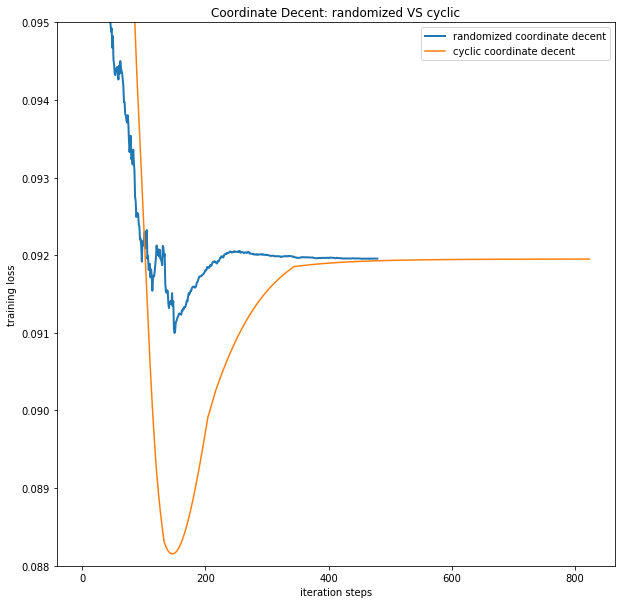

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
line1, = ax.plot(lasso_rcd.train_history, linewidth=2,
                 label='randomized coordinate decent')

line2, = ax.plot(lasso_ccd.train_history,
                 label='cyclic coordinate decent')
ax.set_title('Coordinate Decent: randomized VS cyclic')
ax.set_ylim(0.088,0.095)
ax.set_xlabel('iteration steps')
ax.set_ylabel('training loss')
ax.legend()

#### 0 vs Murphy (ridge regression solution for w)

In [50]:
# cyclic coordinate decent, use Murphy suggestion
lasso_murphy_ccd = LassoRegression(1)
lasso_murphy_ccd.fit(X_train,y_train,init_w = "Murphy")

730.0


LassoRegression(l1reg=1)

In [75]:
# randomized coordinate decent, use Murphy suggestion
lasso_murphy_rcd = LassoRegression(1)
lasso_murphy_rcd.fit(X_train,y_train, init_w = "Murphy",optimize = "rcd")

462.0


LassoRegression(l1reg=1)

#### Compare randomized coordinate descent with different parameter initiations

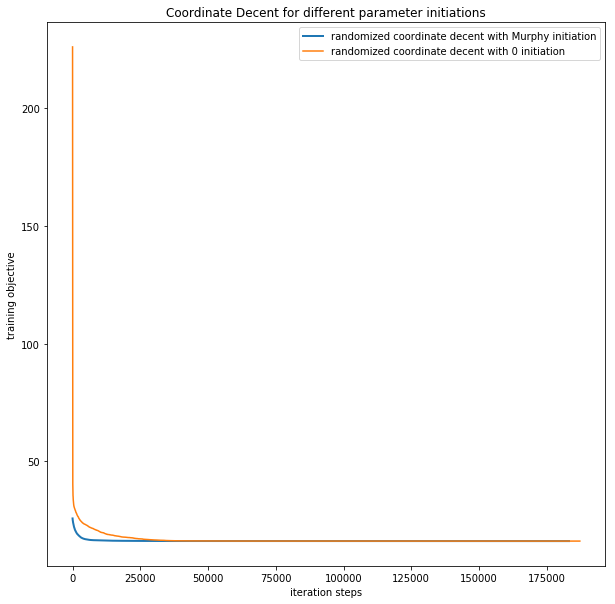

In [312]:
fig, ax = plt.subplots(figsize=(10,10))
line1, = ax.plot(lasso_murphy_rcd.obj_history, linewidth=2,
                 label='randomized coordinate decent with Murphy initiation')

line2, = ax.plot(lasso_rcd.obj_history,
                 label='randomized coordinate decent with 0 initiation')
ax.set_title('Coordinate Decent for different parameter initiations')
ax.set_xlabel('iteration steps')
ax.set_ylabel('training objective')
ax.legend()

#### Compare cyclic coordinate descent with different parameter initiations

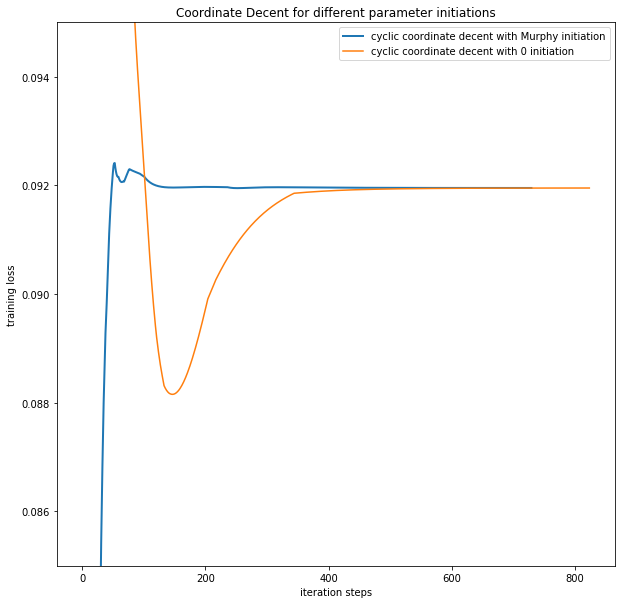

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
line1, = ax.plot(lasso_murphy_ccd.train_history, linewidth=2,
                 label='cyclic coordinate decent with Murphy initiation')

line2, = ax.plot(lasso_ccd.train_history,
                 label='cyclic coordinate decent with 0 initiation')
ax.set_title('Coordinate Decent for different parameter initiations')
ax.set_ylim(0.085,0.095)
ax.set_xlabel('iteration steps')
ax.set_ylabel('training loss')
ax.legend()

In [94]:
len(lasso_murphy_rcd.train_history)

462

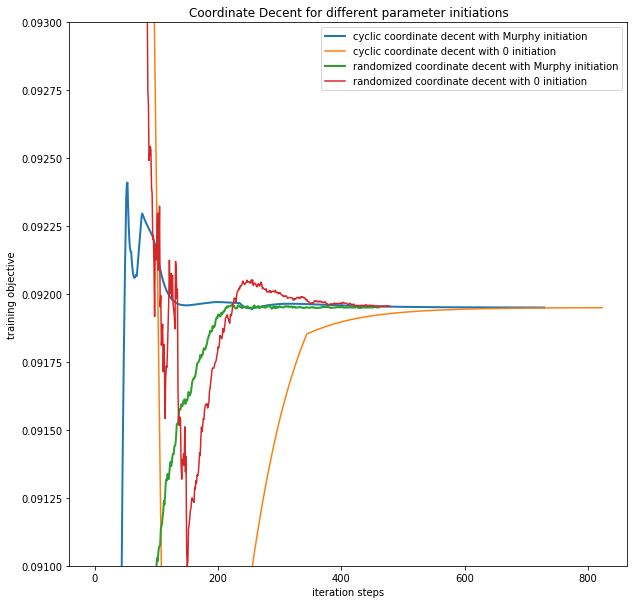

In [89]:
fig, ax = plt.subplots(figsize=(10,10))
line1, = ax.plot(lasso_murphy_ccd.train_history, linewidth=2,
                 label='cyclic coordinate decent with Murphy initiation')

line2, = ax.plot(lasso_ccd.train_history,
                 label='cyclic coordinate decent with 0 initiation')

line3, = ax.plot(lasso_murphy_rcd.train_history, linewidth=2,
                 label='randomized coordinate decent with Murphy initiation')

line4, = ax.plot(lasso_rcd.train_history,
                 label='randomized coordinate decent with 0 initiation')
ax.set_title('Coordinate Decent for different parameter initiations')
ax.set_ylim(0.091,0.093)
ax.set_xlabel('iteration steps')
ax.set_ylabel('training objective')
ax.legend()

In [429]:
lasso_ccd.obj_history[-1]

16.19773797187303

Clearly, Murphy with randomized coordinate descent achieves convergency more quickly

### 3.1.3 Select best $\lambda$

In [95]:
lambda_list = [0.001,0.01, 0.1, 0.5, 1, 10, 20]

134.0
346.0
719.0
502.0
463.0
255.0
234.0


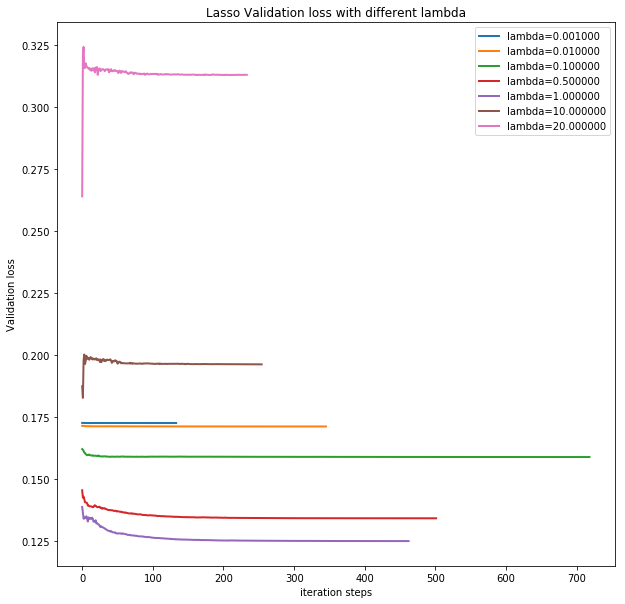

In [96]:
plt.figure(figsize=(10,10))
val_results= []
for l in lambda_list:
    lasso_murphy_rcd_lambda = LassoRegression(l)
    lasso_murphy_rcd_lambda.fit(X_train, y_train, init_w='Murphy', optimize = 'rcd', useValidate = True, X_val = X_test, y_val = y_test)
    val_results.append(lasso_murphy_rcd_lambda.val_history[-1]) 
    plt.plot(lasso_murphy_rcd_lambda.val_history, linewidth=2, label= 'lambda=%f'%l)
plt.title('Lasso Validation loss with different lambda')
plt.xlabel('iteration steps')
plt.ylabel('Validation loss')
plt.legend()

We can see that $\lambda=1$ gives the lowest validation loss

In [108]:
pd.DataFrame(val_results, index = ['0.01','0.01','0.1','0.5','1','10','20'], columns = ['val_loss'])

,val_loss
0.01,0.172423
0.01,0.171026
0.1,0.158712
0.5,0.134010
1,0.124822
10,0.196071
20,0.312779


#### Visualize prediction functions 

In [109]:
pred_fns = []
lambda_list = [0.001,0.01, 0.1, 0.5, 10, 20]
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })


for l in lambda_list:
    lasso_murphy_rcd_lambda = LassoRegression(l)
    lasso_murphy_rcd_lambda.fit(X_train, y_train, init_w='Murphy', optimize = 'rcd')
    pred_fns.append({"name":"Lasso with L1Reg="+str(l),
                 "coefs": lasso_murphy_rcd_lambda.w,
                 "preds": lasso_murphy_rcd_lambda.predict(X) })
    
    
best_lasso = LassoRegression(1)
best_lasso.fit(X_train,y_train, init_w = 'Murphy', optimize = "rcd")
pred_fns.append({"name":"Best Lasso with L1Reg="+str(1),
                 "coefs": best_lasso.w,
                 "preds": best_lasso.predict(X) })


138.0
373.0
708.0
490.0
343.0
257.0
384.0


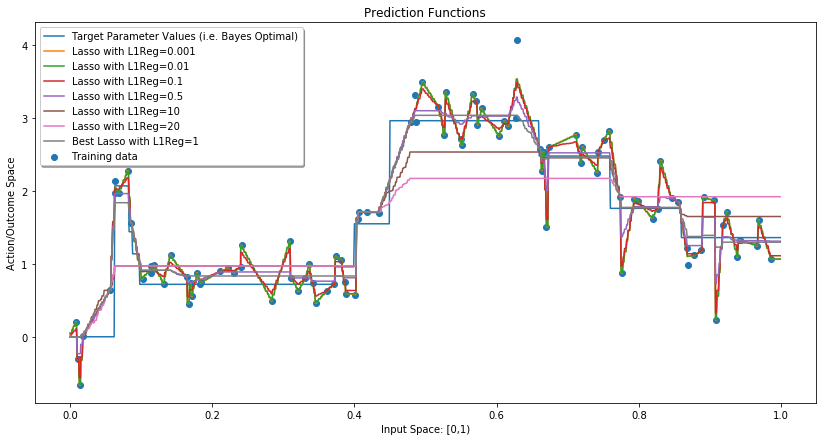

In [111]:
f = rr.plot_prediction_functions(x, pred_fns, x_train, y_train)

#### lasso coefficients

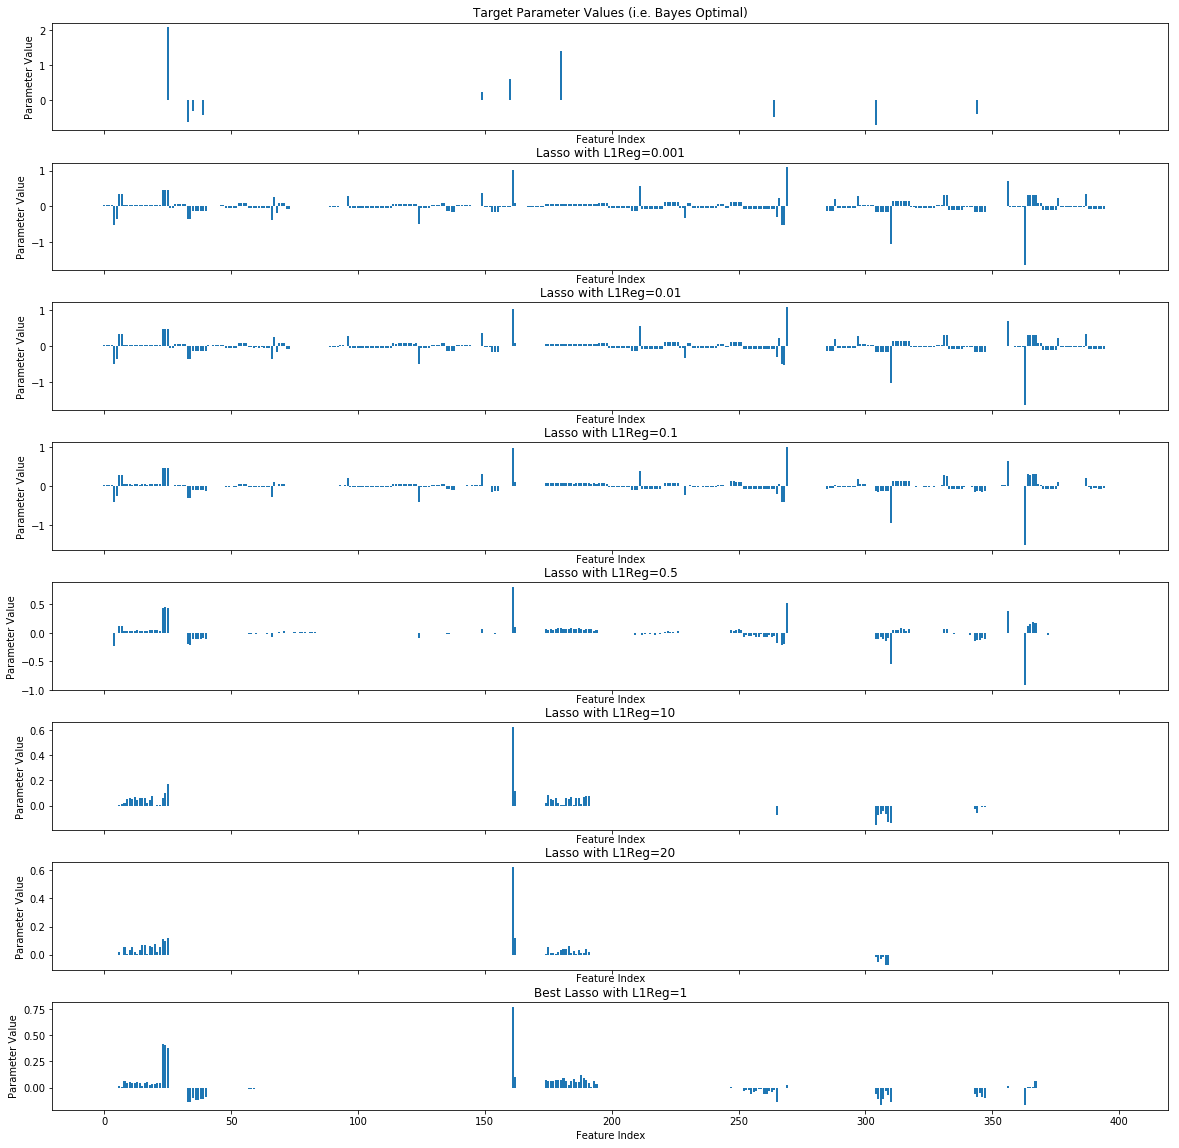

In [113]:
def my_compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize=(20,20))
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

f1 = my_compare_parameter_vectors(pred_fns)

### 3.1.4 Homotpy method (reducing $\lambda$ by a constant factor near 1

In [114]:
lambda_max = 2*np.max(np.abs(np.dot(X_train.T,y_train)))

In [116]:
n,d = X_train.shape
lambdalist = [lambda_max * (0.8**i) for i in range(30)]
avg_val_loss = []
w_zero = np.zeros(d)

for l1reg in lambdalist:
    lasso = LassoRegression(l1reg)
    lasso.fit(X_train,y_train, init_w = "constant", constant_w = w_zero,
              optimize = "rcd",useValidate = True, X_val = X_test, y_val = y_test)
#     w = lasso.w
    avg_val_loss.append(lasso.val_history[-1])
    print(l1reg,": val performance is",lasso.val_history[-1] )

1.0
327.28283232952117 : val performance is 3.5765529343093485
19.0
261.8262658636169 : val performance is 2.5819059201876726
15.0
209.4610126908936 : val performance is 1.945424785632732
16.0
167.5688101527149 : val performance is 1.5331072738460303
133.0
134.05504812217188 : val performance is 1.2203561447577063
130.0
107.24403849773752 : val performance is 0.9155312727625329
61.0
85.79523079819003 : val performance is 0.7194994071372336
254.0
68.63618463855202 : val performance is 0.59416731691805
193.0
54.90894771084163 : val performance is 0.512544483215425
73.0
43.9271581686733 : val performance is 0.4622573693222032
121.0
35.14172653493864 : val performance is 0.4288101050409533
173.0
28.113381227950914 : val performance is 0.4058046882322387
168.0
22.490704982360732 : val performance is 0.35858269716872493
103.0
17.992563985888587 : val performance is 0.28949600826778515
180.0
14.394051188710872 : val performance is 0.2465643327444849
127.0
11.515240950968698 : val performance 

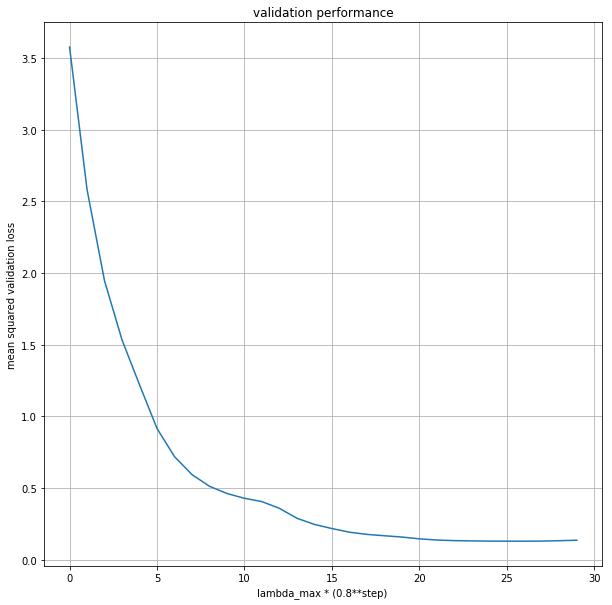

In [117]:
plt.figure(figsize=(10,10))
plt.plot(avg_val_loss)
plt.xlabel("lambda_max * (0.8**step) ")
plt.ylabel("mean squared validation loss")
plt.title("validation performance")
plt.grid()

### 3.1.5 (Optional) Center our data

In [118]:
y_train_centered = y_train - np.mean(y_train)
y_test_centered = y_test - np.mean(y_train)
lambda_max_centered_y = 2*np.max(np.abs(np.dot(X_train.T,y_train_centered)))


In [119]:
n,d = X_train.shape
lambdalist = [lambda_max_centered_y* (0.8**i) for i in range(30)]
avg_val_loss_1 = []
w_zero = np.zeros(d)

for l1reg in lambdalist:
    lasso = LassoRegression(l1reg)
    lasso.fit(X_train,y_train_centered, init_w = "constant", constant_w = w_zero,
              optimize = "rcd",useValidate = True, X_val = X_test, y_val = y_test_centered)
    w = lasso.w
    avg_val_loss_1.append(lasso.val_history[-1])
    print(l1reg,": val performance is",lasso.val_history[-1] )

1.0
66.51995371985255 : val performance is 0.944462865608572
18.0
53.21596297588204 : val performance is 0.8660838464726519
114.0
42.57277038070564 : val performance is 0.8154175430752681
74.0
34.05821630456452 : val performance is 0.7816979592729558
91.0
27.246573043651612 : val performance is 0.669176456023304
130.0
21.79725843492129 : val performance is 0.5438370938250495
127.0
17.437806747937035 : val performance is 0.4284004355092781
165.0
13.950245398349626 : val performance is 0.35618995590064895
65.0
11.160196318679704 : val performance is 0.3046061929395375
280.0
8.928157054943762 : val performance is 0.2644482008489928
88.0
7.14252564395501 : val performance is 0.2390664950948203
94.0
5.714020515164009 : val performance is 0.22301743199961588
125.0
4.571216412131207 : val performance is 0.2004306439218005
176.0
3.6569731297049657 : val performance is 0.17071428224644195
295.0
2.925578503763973 : val performance is 0.15293311770485543
218.0
2.3404628030111785 : val performance

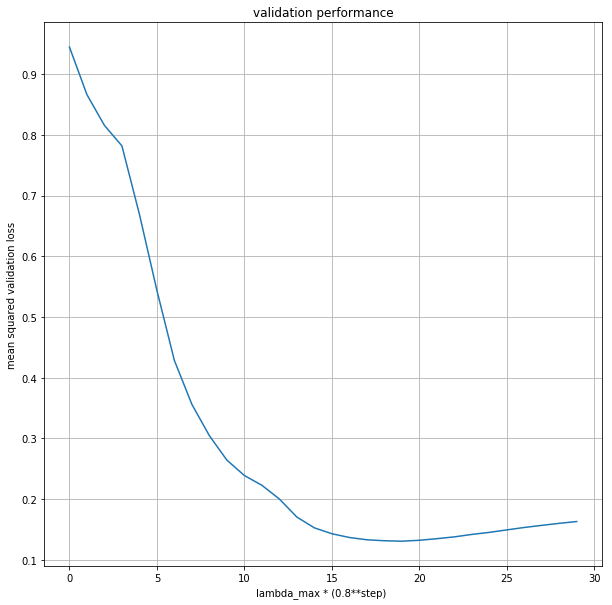

In [120]:
plt.figure(figsize=(10,10))
plt.plot(avg_val_loss_1)
plt.xlabel("lambda_max * (0.8**step) ")
plt.ylabel("mean squared validation loss")
plt.title("validation performance")
plt.grid()

In [150]:
lambdalist_1 = [lambda_max * (0.8**i) for i in range(50)]
avg_val_loss_2=[]
for l1reg in lambdalist_1:
    ridge = rr.RidgeRegression(l1reg)
    ridge.fit(X_train,y_train)
    score = ridge.score(X_test, y_test)
    avg_val_loss_2.append(score)
    print(l1reg,": val performance is", score)

327.28283232952117 : val performance is 1.9377639642862472
261.8262658636169 : val performance is 1.737961299944234
209.4610126908936 : val performance is 1.5427532953929477
167.5688101527149 : val performance is 1.3582152595036243
134.05504812217188 : val performance is 1.189382188309975
107.24403849773752 : val performance is 1.039638254333431
85.79523079819003 : val performance is 0.9104409377508819
68.63618463855202 : val performance is 0.8014213806033499
54.90894771084163 : val performance is 0.7107876334792769
43.9271581686733 : val performance is 0.6358780737321181
35.14172653493864 : val performance is 0.5737115542205313
28.113381227950914 : val performance is 0.5214226061159467
22.490704982360732 : val performance is 0.47653894520182233
17.992563985888587 : val performance is 0.43710710520781815
14.394051188710872 : val performance is 0.40170878910329
11.515240950968698 : val performance is 0.3694065283439917
9.212192760774958 : val performance is 0.3396574913432024
7.36975420

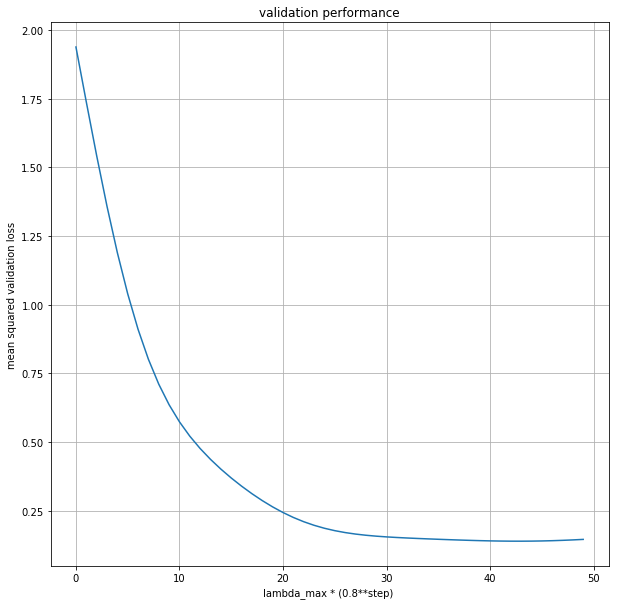

In [151]:
plt.figure(figsize=(10,10))
plt.plot(avg_val_loss_2)
plt.xlabel("lambda_max * (0.8**step) ")
plt.ylabel("mean squared validation loss")
plt.title("validation performance")
plt.grid()

In [152]:
np.argmin(avg_val_loss_2)

43

In [144]:
n,d = X_train.shape
lambdalist_2 = [lambda_max_centered_y* (0.8**i) for i in range(50)]
avg_val_loss_3 = []
w_zero = np.zeros(d)

for l1reg in lambdalist_2:
    ridge = rr.RidgeRegression(l1reg)
    ridge.fit(X_train,y_train_centered)
    score = ridge.score(X_test, y_test_centered)
    avg_val_loss_3.append(score)
    print(l1reg,": val performance is", score)

66.51995371985255 : val performance is 0.7909513807652226
53.21596297588204 : val performance is 0.7689791328536459
42.57277038070564 : val performance is 0.7441615811023029
34.05821630456452 : val performance is 0.7163369573647841
27.246573043651612 : val performance is 0.6855031904657295
21.79725843492129 : val performance is 0.6518672853862876
17.437806747937035 : val performance is 0.6158882442776966
13.950245398349626 : val performance is 0.5782710101489009
11.160196318679704 : val performance is 0.539936575048983
8.928157054943762 : val performance is 0.5019377674831017
7.14252564395501 : val performance is 0.4653438316813784
5.714020515164009 : val performance is 0.43108866935893
4.571216412131207 : val performance is 0.399881740835897
3.6569731297049657 : val performance is 0.3721195134120558
2.925578503763973 : val performance is 0.3478746052752182
2.3404628030111785 : val performance is 0.3269487992693423
1.8723702424089428 : val performance is 0.30894340782028445
1.497896193

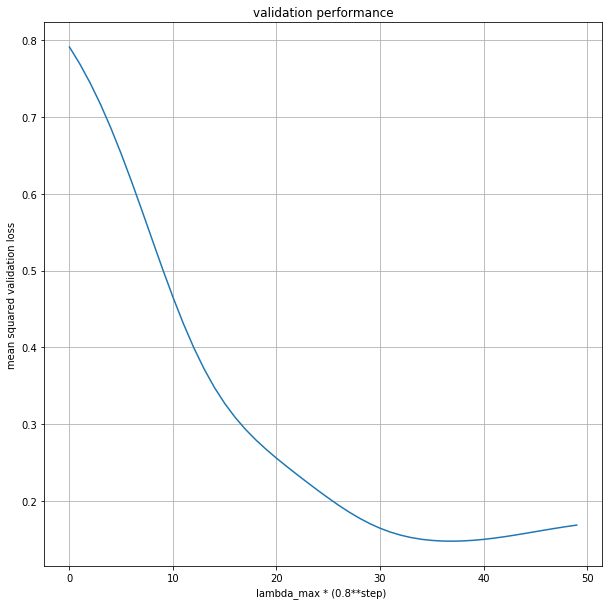

In [145]:
plt.figure(figsize=(10,10))
plt.plot(avg_val_loss_3)
plt.xlabel("lambda_max * (0.8**step) ")
plt.ylabel("mean squared validation loss")
plt.title("validation performance")
plt.grid()

In [146]:
np.argmin(avg_val_loss_3)

37